In [1]:
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# ======================
# Configuration Parameters
# ======================
CONFIG = {
    'target_size': (224, 224),
    'data_type': sitk.sitkFloat32,
    'registration': {
        'shrink_factors': [2, 1],
        'smoothing_sigmas': [1, 0],
        'metric': 'MeanSquares',
        'optimizer': 'RegularStepGradientDescent',
        'learning_rate': 0.1,
        'min_step': 1e-5,  
        'iterations': 100,
        'transform': 'Euler2DTransform',
        'interpolator': sitk.sitkLinear
    }
}

In [3]:
# ======================
# Image Processing Utilities
# ======================
def aspect_preserving_resize(image, target_size):
    """Resize image while maintaining aspect ratio with padding"""
    h, w = image.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_h/h, target_w/w)
    new_h, new_w = int(h*scale), int(w*scale)
    
    # Resize with preserved aspect ratio
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Create padded image
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left
    
    padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, 
                               pad_left, pad_right, 
                               cv2.BORDER_CONSTANT, value=0)
    return padded

In [4]:
# ======================
# Template Preparation
# ======================
def create_template(template_path):
    """Create template with proper aspect ratio handling"""
    # Read and process template
    template_3d = sitk.ReadImage(template_path)
    template_array = sitk.GetArrayFromImage(template_3d).astype(np.float32)
    
    # Extract middle slice with aspect preservation
    z_index = template_array.shape[0] // 2
    template_slice = template_array[z_index, :, :]
    template_padded = aspect_preserving_resize(template_slice, CONFIG['target_size'])
    
    # Create SimpleITK image
    template = sitk.GetImageFromArray(template_padded)
    template = sitk.Cast(template, CONFIG['data_type'])
    template.SetSpacing([1.0, 1.0])
    return template

In [5]:
# ======================
# Registration Core (Fixed)
# ======================
def register_image(moving_image, fixed_image):
    """Rigid registration with aspect ratio preservation"""
    # Ensure matching data types
    moving_image = sitk.Cast(moving_image, CONFIG['data_type'])
    fixed_image = sitk.Cast(fixed_image, CONFIG['data_type'])
    
    # Configure registration
    reg_method = sitk.ImageRegistrationMethod()
    reg_method.SetMetricAsMeanSquares()
    
    # Fixed: Added missing minStep parameter
    reg_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=CONFIG['registration']['learning_rate'],
        minStep=CONFIG['registration']['min_step'], 
        numberOfIterations=CONFIG['registration']['iterations']
    )
    
    # Multi-resolution setup
    reg_method.SetShrinkFactorsPerLevel(CONFIG['registration']['shrink_factors'])
    reg_method.SetSmoothingSigmasPerLevel(CONFIG['registration']['smoothing_sigmas'])
    
    # Rigid transform configuration
    initial_transform = sitk.Euler2DTransform()
    reg_method.SetInitialTransform(initial_transform)
    
    # Execute registration
    final_transform = reg_method.Execute(fixed_image, moving_image)
    
    # Apply transformation
    registered = sitk.Resample(moving_image, fixed_image, final_transform,
                             CONFIG['registration']['interpolator'], 0.0)
    return registered

In [6]:
# ======================
# Pipeline Functions
# ======================
def load_image(file_path):
    """Load and preprocess image with aspect preservation"""
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    processed = aspect_preserving_resize(img, CONFIG['target_size'])
    img_normalized = (processed - processed.min()) / (processed.max() - processed.min() + 1e-6)
    sitk_img = sitk.GetImageFromArray(img_normalized.astype(np.float32))
    return sitk.Cast(sitk_img, CONFIG['data_type'])

def process_dataset(input_dir, output_dir, template):
    """Process full dataset with aspect preservation"""
    os.makedirs(output_dir, exist_ok=True)
    
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        output_class_path = os.path.join(output_dir, class_dir)
        os.makedirs(output_class_path, exist_ok=True)
        
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing: {class_path}"):
            input_path = os.path.join(class_path, file_name)
            output_path = os.path.join(output_class_path, file_name)
            
            try:
                # Load and register
                moving_img = load_image(input_path)
                registered = register_image(moving_img, template)
                
                # Convert and save
                registered_np = sitk.GetArrayFromImage(registered)
                cv2.imwrite(output_path, (registered_np * 255).astype(np.uint8))
                
            except Exception as e:
                print(f"Error processing {input_path}: {str(e)}")

In [7]:
# ======================
# Main Execution
# ======================

# https://purl.stanford.edu/ng782rw8378
#template_3d_path = "SUB1_t1.nii.gz"

# https://www.templateflow.org/browse/
#template_3d_path = "tpl-MNI152NLin2009cSym_res-1_T1w.nii.gz"
template_3d_path = "tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz" # This one better for classification

template = create_template(template_3d_path)
# Process dataset
process_dataset(input_dir= "Brain tumor_D2_Original",
                output_dir= "Brain tumor_D2_Template registration",
                template=template)

Processing: Brain tumor_D2_Original\pituitary: 100%|██████████| 300/300 [09:17<00:00,  1.86s/it]


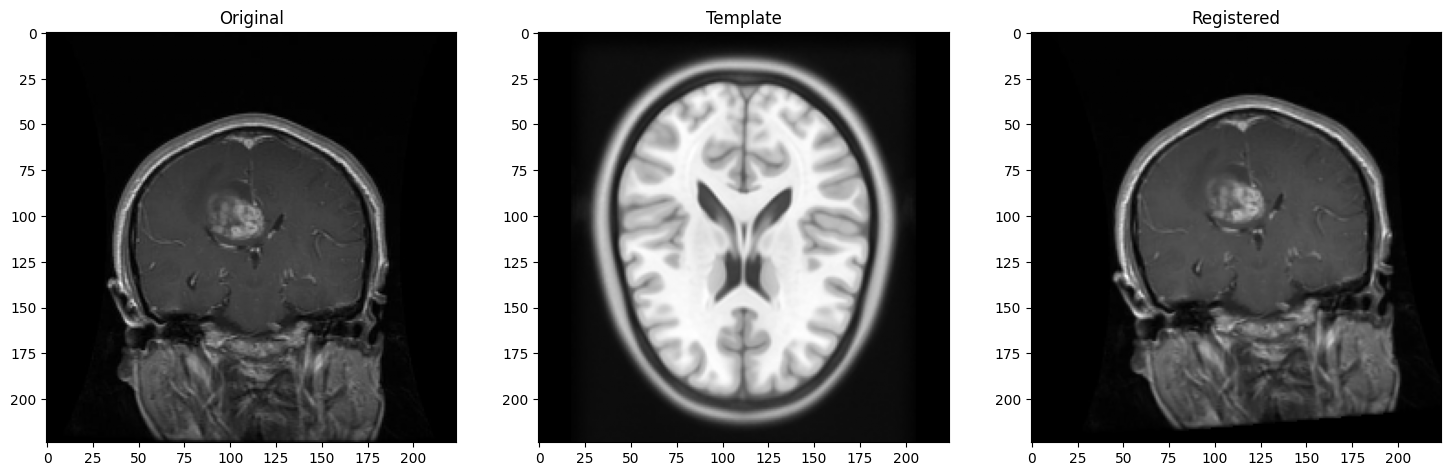

In [8]:
file_path = r"Brain tumor_D2_Original\glioma\Te-gl_0040.jpg"

if os.path.exists(file_path):
    test_img = load_image(file_path)
    registered = register_image(test_img, template)

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(sitk.GetArrayFromImage(test_img), cmap='gray')
    ax[0].set_title('Original')
    ax[1].imshow(sitk.GetArrayFromImage(template), cmap='gray')
    ax[1].set_title('Template')
    ax[2].imshow(sitk.GetArrayFromImage(registered), cmap='gray')
    ax[2].set_title('Registered')
    plt.show()
else:
    print(f"Error: File not found -> {file_path}")